<center>

# <font style="color:orange;"> **Capstone Project - CRM Analysis**</font></center>

---

## **Data Import & Preprocessing**

In [119]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [120]:
# importing data from CSV file into a Pandas DataFrame
df_import = pd.read_csv('D:\ml\github\crm-analysis\ecom_crm_analysis.csv')

### Data Features

In [121]:
df_import.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [122]:
# Data Info
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [123]:
# null values in each column
print(df_import.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [124]:
df_import.duplicated().sum()

np.int64(5268)

In [125]:
print(f'No. of null records in Customer Id column is ',df_import['CustomerID'].isnull().sum(),'in percentage',round(df_import['CustomerID'].isnull().sum()/df_import.shape[0]*100,2))

No. of null records in Customer Id column is  135080 in percentage 24.93


In [126]:
df_import = df_import.drop_duplicates()

In [127]:
print(df_import.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


In [128]:
# Create a mapping of InvoiceNo to CustomerID, ignoring null CustomerIDs
invoice_to_customer = df_import.loc[df_import['CustomerID'].notna(), ['InvoiceNo', 'CustomerID']].drop_duplicates()

# Convert to a dictionary
invoice_to_customer_dict = dict(zip(invoice_to_customer['InvoiceNo'], invoice_to_customer['CustomerID']))


In [129]:
# Fill missing CustomerID using the mapping
df_import['CustomerID'] = df_import['CustomerID'].fillna(df_import['InvoiceNo'].map(invoice_to_customer_dict))

In [130]:
print(df_import.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


In [131]:
# Creating the 'InvoiceType' column
df_import['InvoiceType'] = 'Purchase'  # Default value

# set invoice type to Cancellation where InvoiceNo starts with C
df_import.loc[df_import['InvoiceNo'].str.startswith('C'), 'InvoiceType'] = 'Cancellation'

# Apply conditions for 'Free Item'
df_import.loc[df_import['UnitPrice'] == 0 & (df_import['Quantity'] > 0), 'InvoiceType'] = 'Free Item'

# for negative quantities
df_import.loc[((~df_import['InvoiceNo'].str.startswith('C')) & (df_import['Quantity'] < 0)), 'InvoiceType'] = 'Return'

In [132]:
# dropping all the columns with no customer ID as it's crucial for CRM
df = df_import.dropna(subset=['CustomerID'])
df.shape

(401604, 9)

In [133]:
# null values in each column
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceType    0
dtype: int64


In [134]:
df_import.duplicated().sum()

np.int64(0)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
 8   InvoiceType  401604 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 30.6+ MB


### **Outliers and Outlier Treatment**

In [136]:
cont_col = ['Quantity', 'UnitPrice']

In [137]:
print(df[cont_col].describe())  # Summarize column statistics

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000


In [138]:
# Function to calclutae the IQR, Lower Bound and Upper Bound
def calculate_iqr(df,col):
  q3 = df[col].quantile(0.75)
  q1 = df[col].quantile(0.25)
  iqr = q3-q1
  lower_bound = q1 - 1.5*iqr
  upper_bound = q3 + 1.5*iqr
  return lower_bound,upper_bound,iqr

for col in cont_col:
  lower_bound,upper_bound,iqr = calculate_iqr(df,col)
  df_outlier = df[(df[col] < (lower_bound)) | (df[col] > (upper_bound))]
  print(f'{col} - {df_outlier.shape[0]}, in percentage {round((df_outlier.shape[0]/df.shape[0])*100,2)}')

Quantity - 26646, in percentage 6.63
UnitPrice - 35802, in percentage 8.91


In [139]:
percentile_0 = np.percentile(df['UnitPrice'], 0)
percentile_91 = np.percentile(df['UnitPrice'], 91)
df['UnitPrice'] = np.round(np.clip(df['UnitPrice'], percentile_0, percentile_91),2)

percentile_0 = np.percentile(df['Quantity'], 0.3)
percentile_91 = np.percentile(df['Quantity'], 93)
df['Quantity'] = np.round(np.clip(df['Quantity'], percentile_0, percentile_91),2)

In [140]:
for col in cont_col:
  lower_bound,upper_bound,iqr = calculate_iqr(df,col)
  df_outlier = df[(df[col] < (lower_bound)) | (df[col] > (upper_bound))]
  print(f'{col} - {df_outlier.shape[0]}, in percentage {round((df_outlier.shape[0]/df.shape[0])*100,2)}')

Quantity - 0, in percentage 0.0
UnitPrice - 0, in percentage 0.0


## **Feature Engineering**

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
 8   InvoiceType  401604 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 30.6+ MB


- Change the datatype for invoice to `pd.to_datetime()`
- Create new features like `InvoiceType`, `RFM Values` etc


In [142]:
df[df['InvoiceDate'].str.contains(r'/', na=False)].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceType
26732,538521,21754,HOME BUILDING BLOCK WORD,3,12/13/2010 9:02,5.95,14180.0,United Kingdom,Purchase
26733,538521,21755,LOVE BUILDING BLOCK WORD,3,12/13/2010 9:02,5.95,14180.0,United Kingdom,Purchase
26734,538521,22072,RED RETROSPOT TEA CUP AND SAUCER,8,12/13/2010 9:02,3.75,14180.0,United Kingdom,Purchase


In [143]:
df[df['InvoiceDate'].str.contains(r'-', na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom,Purchase
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,Purchase
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom,Purchase
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,Purchase
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,Purchase


In [144]:
df['InvoiceDate'] = df['InvoiceDate'].str.replace('-', '/', regex=False)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [145]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['CustomerID'] = df['CustomerID'].astype('category')

In [146]:
df['TransactionMonth'] = df['InvoiceDate'].dt.strftime('%b')

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         401604 non-null  object        
 1   StockCode         401604 non-null  object        
 2   Description       401604 non-null  object        
 3   Quantity          401604 non-null  int64         
 4   InvoiceDate       401604 non-null  datetime64[ns]
 5   UnitPrice         401604 non-null  float64       
 6   CustomerID        401604 non-null  category      
 7   Country           401604 non-null  object        
 8   InvoiceType       401604 non-null  object        
 9   Month             401604 non-null  period[M]     
 10  TransactionMonth  401604 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 34.6+ MB


In [148]:
df['PrevPurchaseDate'] = df.groupby('CustomerID')['InvoiceDate'].shift()
df['DaysBetweenPurchases'] = (df['InvoiceDate'] - df['PrevPurchaseDate']).dt.days

# Peak shopping hours
print("-"*25)
df['Hour'] = df['InvoiceDate'].dt.hour
peak_hours = df['Hour'].value_counts().sort_values(ascending=False)
print(peak_hours)

# Preferred shopping days
print("-"*25)
df['DayInWeek'] = df['InvoiceDate'].dt.day_name()
preferred_days = df['DayInWeek'].value_counts()
print(preferred_days)

#df['InvoiceDate'] = df['InvoiceDate'].dt.date

-------------------------
Hour
12    72213
13    64051
14    54194
11    49525
15    45641
10    38725
16    24618
9     22446
17    13604
8      8789
19     3423
18     3104
20      847
7       383
6        41
Name: count, dtype: int64
-------------------------
DayInWeek
Thursday     81575
Wednesday    69753
Tuesday      67376
Monday       65715
Sunday       61673
Friday       55512
Name: count, dtype: int64


In [149]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [150]:
df['Country'] = df['Country'].astype('category')
df['InvoiceType'] = df['InvoiceType'].astype('category')

In [151]:
# df = df[df['TotalPrice'] > 0]

In [152]:
df.isna().sum()

InvoiceNo                  0
StockCode                  0
Description                0
Quantity                   0
InvoiceDate                0
UnitPrice                  0
CustomerID                 0
Country                    0
InvoiceType                0
Month                      0
TransactionMonth           0
PrevPurchaseDate        4372
DaysBetweenPurchases    4372
Hour                       0
DayInWeek                  0
TotalPrice                 0
dtype: int64

## **EDA &Specific Metrics**

#### **EDA**

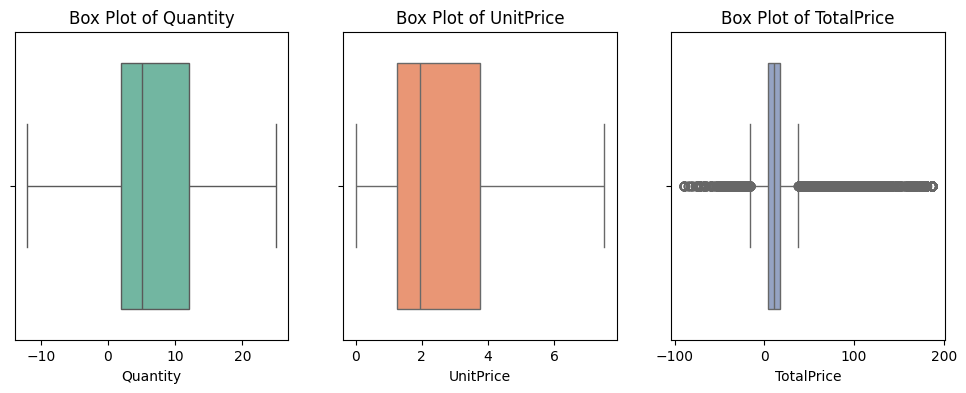

In [153]:
att = ['Quantity', 'UnitPrice', 'TotalPrice']

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
palette = sns.color_palette('Set2', 3)
plot_number = 0
k=0
for i in range(3):
    sns.boxplot(data=df, x=att[plot_number], ax=axes[i], color=palette[k])
    axes[i].set_title(f"Box Plot of {att[plot_number]}")
    axes[i].set_xlabel(att[plot_number])
    plot_number += 1
    k += 1
plt.show()

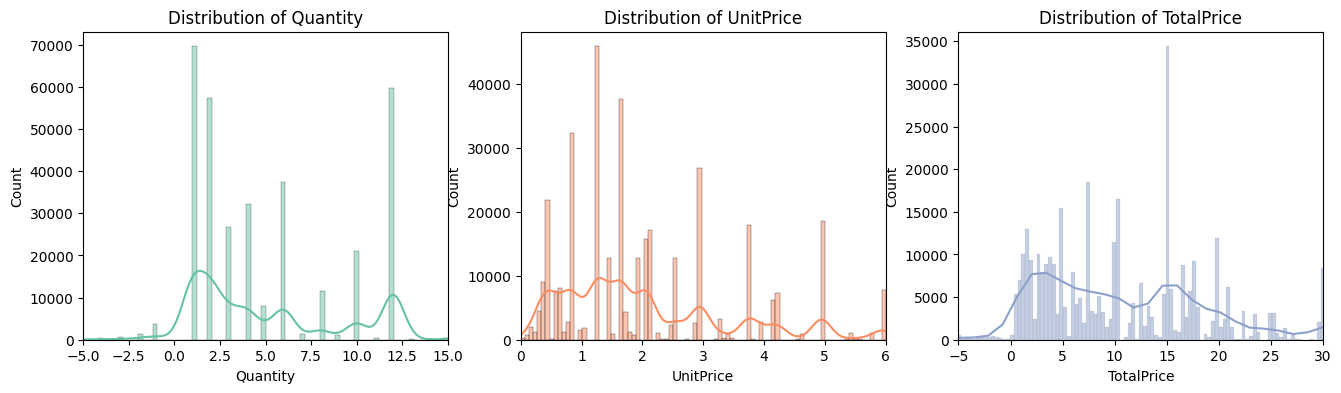

In [154]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
palette = sns.color_palette('Set2', 3)
limits = [[-5,15],[0,6],[-5,30]]
plot_number = 0
k=0
for i in range(3):
    sns.histplot(data=df, x=att[plot_number], ax=axes[i], kde = True, color=palette[k])
    axes[i].set_title(f"Distribution of {att[plot_number]}")
    axes[i].set_xlabel(att[plot_number])
    axes[i].set_xlim(limits[k][0],limits[k][1])  # excluding extreme outliers for better visualization
    plot_number += 1
    k += 1
plt.show()

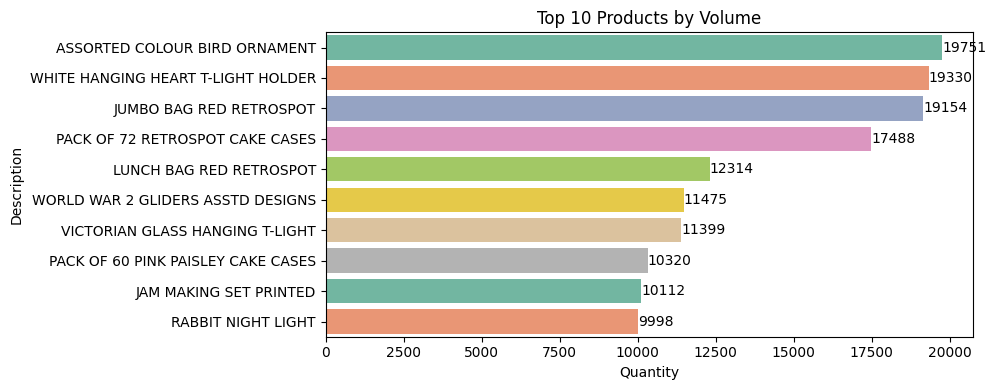

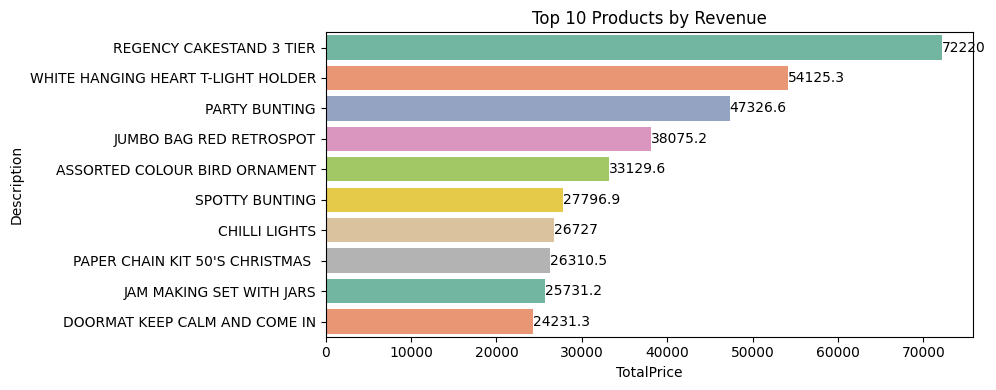

In [155]:
top_products_vol = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
top_products_rev = df.query('InvoiceType == "Purchase"').groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

#top 10 by volume
plt.figure(figsize=(10, 4))
ax = sns.barplot(y='Description',x = 'Quantity', data = top_products_vol, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Top 10 Products by Volume')
plt.tight_layout()
plt.show()

#top 10 by revenue
plt.figure(figsize=(10, 4))
ax = sns.barplot(y='Description',x = 'TotalPrice', data = top_products_rev, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()

In [156]:
monthly_sales = df.groupby('Month').agg({'TotalPrice': 'sum'}).reset_index()
monthly_orders = df.groupby('Month')['InvoiceNo'].nunique().reset_index()

monthly_sales['Number of Orders'] = monthly_orders['InvoiceNo']
monthly_sales['Average Order Value'] = monthly_sales['TotalPrice'] / monthly_sales['Number of Orders']
monthly_sales.rename(columns={'TotalPrice': 'Total Revenue'}, inplace=True)

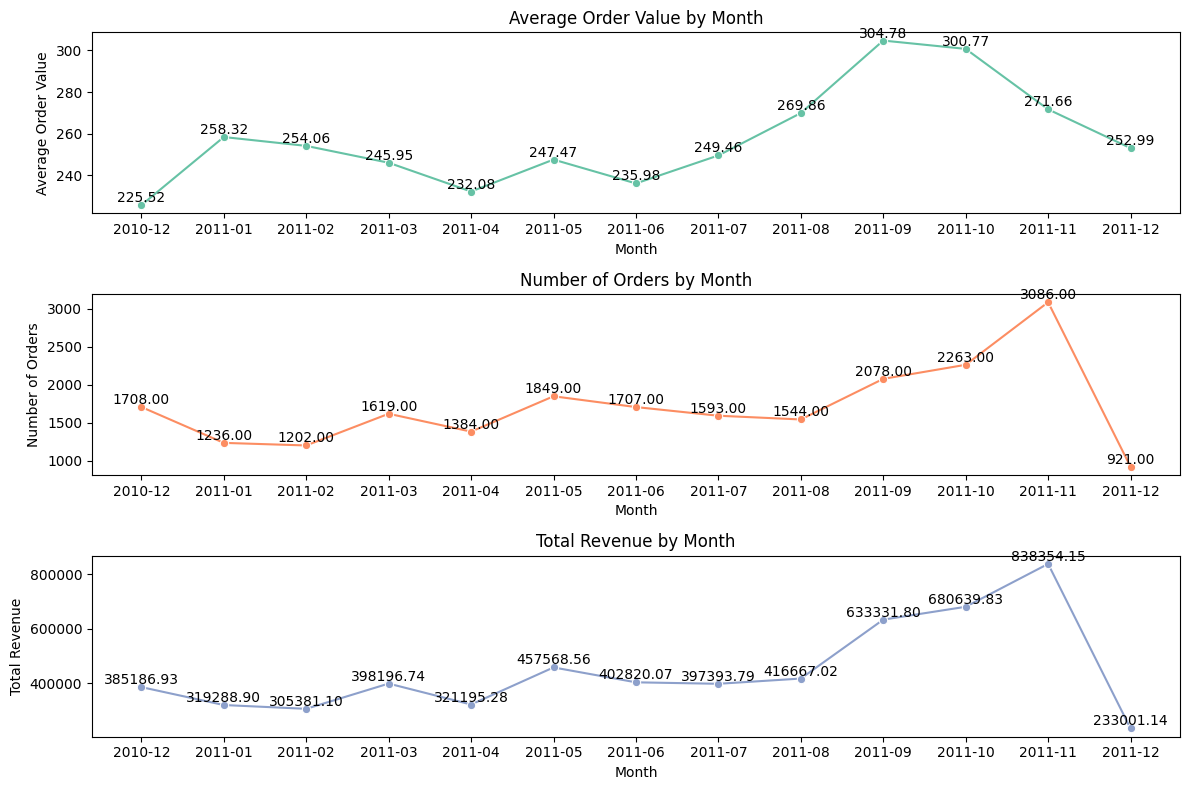

In [157]:
monthly_sales['Month'] = monthly_sales['Month'].astype(str)
iter = ['Average Order Value','Number of Orders','Total Revenue']

fig, axes = plt.subplots(nrows = 3, ncols = 1,figsize = (12,8))
k=0
for i in range(3):
    sns.lineplot(x = monthly_sales['Month'], y = monthly_sales[iter[k]], marker = 'o', ax = axes[i], color = palette[k])
    for x, y in zip(monthly_sales['Month'], monthly_sales[iter[k]]):
        axes[i].text(x, y, f'{y:.2f}', ha='center', va='bottom')
    axes[i].set_ylabel(f'{iter[k]}')
    axes[i].set_title(f"{iter[k]} by Month")
    axes[i].set_xlabel('Month')
    k += 1

plt.tight_layout()
plt.show()

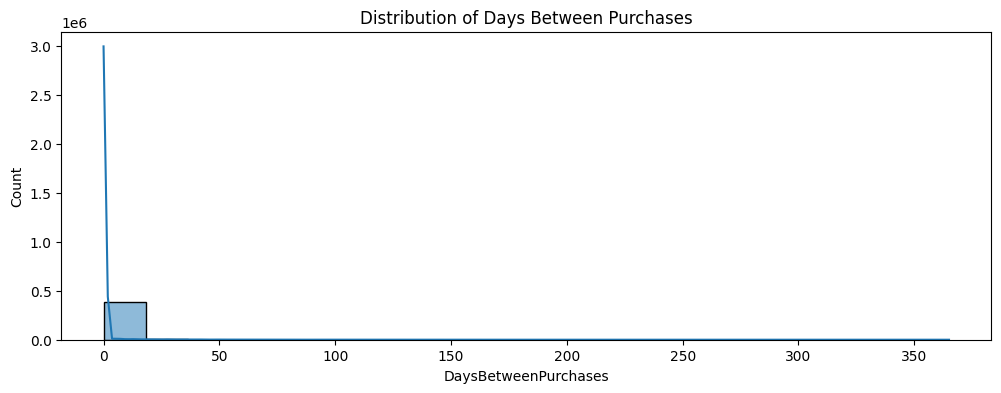

In [158]:
plt.figure(figsize=(12, 4))
sns.histplot(df['DaysBetweenPurchases'], kde=True)
plt.title('Distribution of Days Between Purchases')
plt.show()

In [159]:
purchase = df.groupby(['InvoiceNo'])['InvoiceDate'].value_counts().reset_index()
purchase['Hour'] = purchase['InvoiceDate'].dt.hour
purchase['DayInWeek'] = purchase['InvoiceDate'].dt.day_name()

In [160]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
purchase['DayInWeek'] = pd.Categorical(purchase['DayInWeek'], categories=day_order, ordered=True)

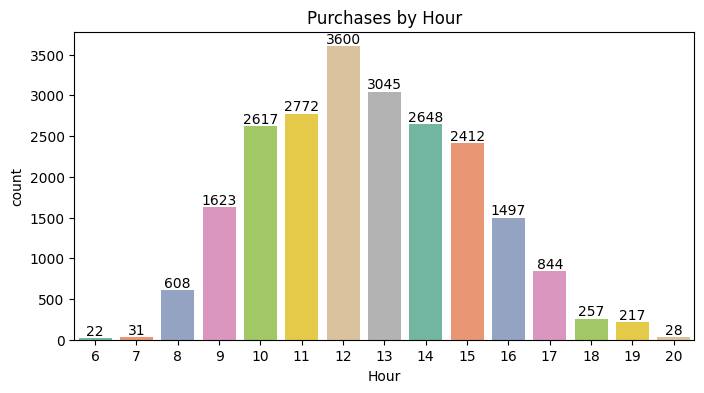

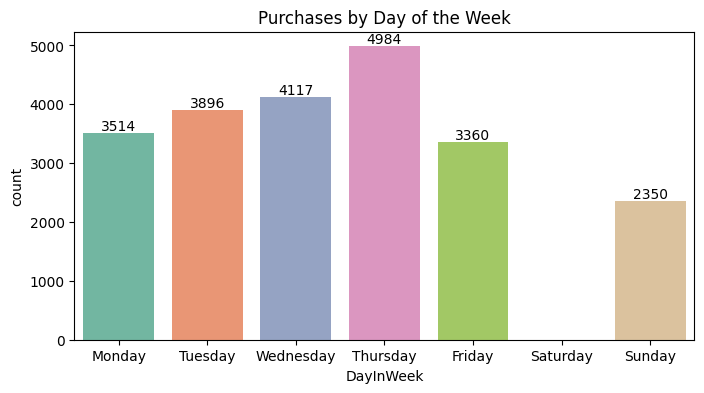

In [161]:
# Purchases by Hour
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Hour', data=purchase, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Purchases by Hour')
plt.show()

# Purchases by Day of the Week
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='DayInWeek', data=purchase, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Purchases by Day of the Week')
plt.show()


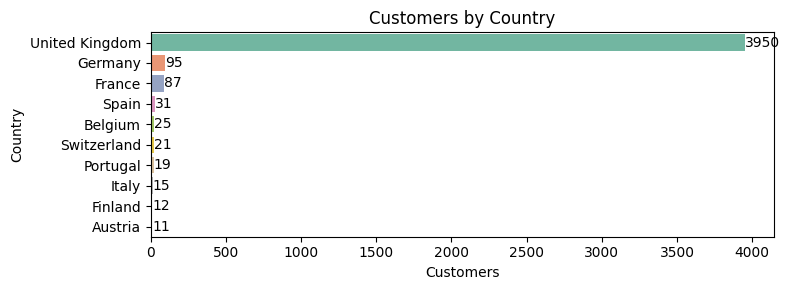

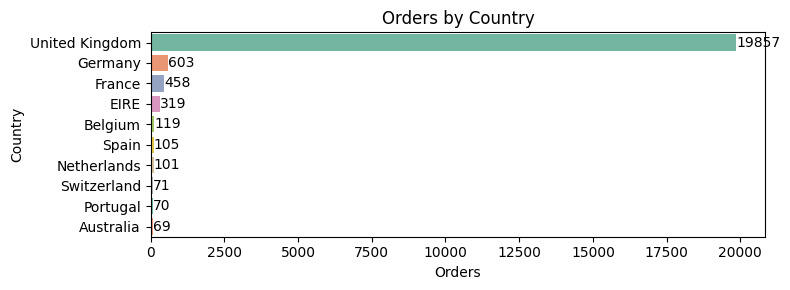

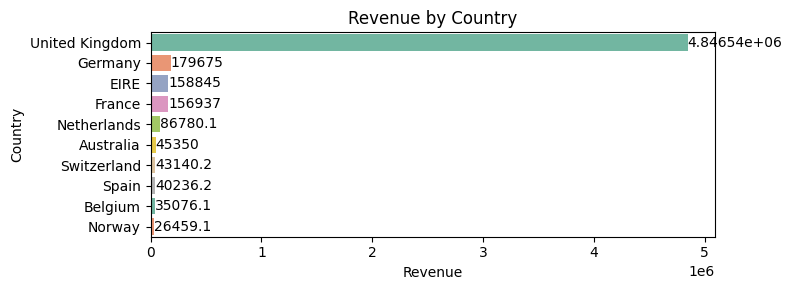

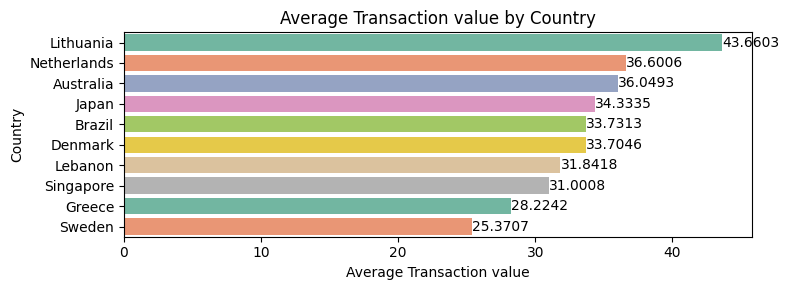

In [162]:
agg_configs = [
    {'value_col': 'CustomerID', 'agg_func': 'nunique', 'xlabel': 'Customers'},
    {'value_col': 'InvoiceNo', 'agg_func': 'nunique', 'xlabel': 'Orders'},
    {'value_col': 'TotalPrice', 'agg_func': 'sum', 'xlabel': 'Revenue'},
    {'value_col': 'TotalPrice', 'agg_func': 'mean', 'xlabel': 'Average Transaction value'}]

for config in agg_configs:
    aggregated_data = df.groupby('Country')[config['value_col']].agg(config['agg_func']).reset_index()
    aggregated_data = aggregated_data.rename(columns={config['value_col']: config['xlabel']})
    aggregated_data = aggregated_data.sort_values(by=config['xlabel'], ascending=False).head(10)

    plt.figure(figsize=(8, 3))
    ax = sns.barplot(y='Country', x=config['xlabel'], data=aggregated_data, palette='Set2', order=aggregated_data['Country'])
    for container in ax.containers:
      ax.bar_label(container)
    plt.title(f"{config['xlabel']} by Country")
    plt.xlabel(config['xlabel'])
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   InvoiceNo             401604 non-null  object        
 1   StockCode             401604 non-null  object        
 2   Description           401604 non-null  object        
 3   Quantity              401604 non-null  int64         
 4   InvoiceDate           401604 non-null  datetime64[ns]
 5   UnitPrice             401604 non-null  float64       
 6   CustomerID            401604 non-null  category      
 7   Country               401604 non-null  category      
 8   InvoiceType           401604 non-null  category      
 9   Month                 401604 non-null  period[M]     
 10  TransactionMonth      401604 non-null  object        
 11  PrevPurchaseDate      397232 non-null  datetime64[ns]
 12  DaysBetweenPurchases  397232 non-null  float64       
 13  Hour

### **Customer Segmentation**

#### **RFM Analysis**

In [164]:
df['CustomerID'].nunique()

4372

In [165]:
# df = df[df['TotalPrice'] > 0]
df['CustomerID'].nunique()

4372

In [172]:
# Recency: Days since last transaction
reference_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum' 
}).rename(columns={'InvoiceDate': 'recency', 'InvoiceNo': 'frequency', 'TotalPrice': 'monetary'}).reset_index()

print(rfm.head())

  CustomerID  recency  frequency  monetary
0    12346.0      325          2     13.52
1    12347.0        1          7   3852.98
2    12348.0       74          4    527.95
3    12349.0       18          1   1331.65
4    12350.0      309          1    301.90


In [173]:
rfm['R_Score'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['frequency'], 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

ValueError: Bin edges must be unique: Index([1.0, 1.0, 3.0, 5.0, 248.0], dtype='float64', name='frequency').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [168]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CustomerID  4372 non-null   category
 1   recency     4372 non-null   int64   
 2   frequency   4372 non-null   int64   
 3   monetary    4372 non-null   float64 
 4   R_Score     4372 non-null   category
 5   F_Score     4372 non-null   category
 6   M_Score     4372 non-null   category
dtypes: category(4), float64(1), int64(2)
memory usage: 287.7 KB


In [169]:
# RFM score by adding all the scores
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

In [117]:
rfm.head()

,CustomerID,recency,frequency,monetary,R_Score,F_Score,M_Score
0,12346.0,325.0,1,26.00,1,1,1
1,12347.0,1.0,7,3852.98,4,1,4
2,12348.0,74.0,4,527.95,4,1,2
3,12349.0,18.0,1,1331.65,4,1,3
4,12350.0,309.0,1,301.90,1,1,2




*   **Lost** --> Customers with lowest RFM Score
*   **At-Risk** --> Customers with less engagement and spending
*   **Potential High Value** --> Moderate score and has good chance of becoming Loyal customers with proper strategy
*   **Loyal** --> Most valuable customer with consistent spending and engagement

In [170]:
rfm['RFM_Score'].max()

np.int64(12)

In [171]:
# Segment customers
rfm['segment'] = pd.cut(rfm['RFM_Score'], bins=[2, 5, 7, 9, 12], labels=['Lost','At-Risk', 'Potential High Value', 'Loyal'])
print(rfm['segment'].value_counts())

segment
Potential High Value    1901
At-Risk                 1525
Lost                     932
Loyal                     14
Name: count, dtype: int64


In [ ]:
2 3 4 5  6 7   8 9  10 11 12

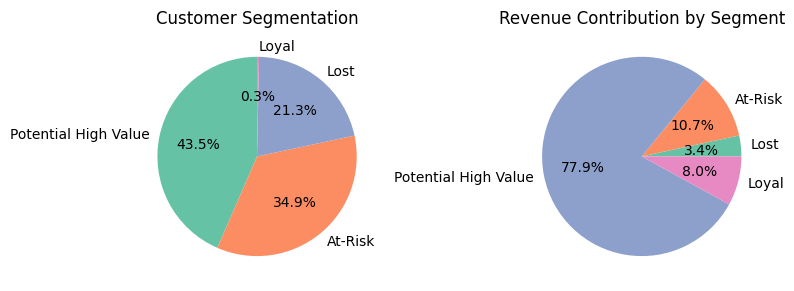

In [63]:
fig,axes = plt.subplots(1, 2, figsize = (8,4))
set2_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']
rfm['segment'].value_counts().plot.pie(autopct='%1.1f%%', ax = axes[0], startangle=90, colors = set2_colors[:4])
axes[0].set_title('Customer Segmentation')
axes[0].set_ylabel('')
# plt.subplot(1,2,1)
rfm.groupby('segment')['monetary'].sum().plot(kind='pie', autopct='%1.1f%%', ax = axes[1], colors = set2_colors[:4])
axes[1].set_title('Revenue Contribution by Segment')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

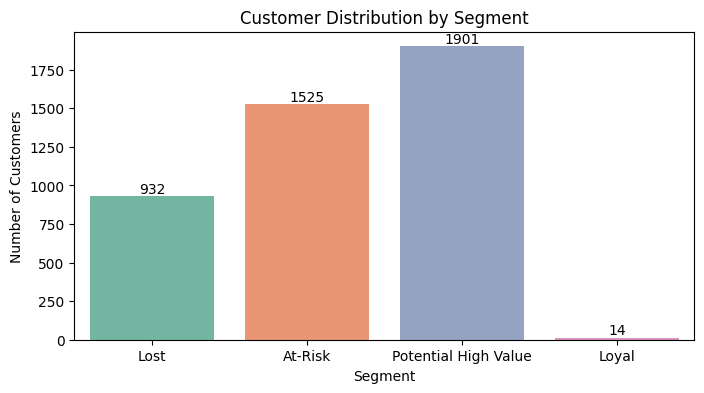

In [64]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='segment', data=rfm, palette='Set2')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Customer Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=rfm.groupby('Segment')['Monetary'].mean().index, y=rfm.groupby('Segment')['Monetary'].mean().values, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value')
plt.title('Average Monetary Value by Segment')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(rfm['Monetary'], bins=50, kde=True, palette='Set2')
plt.title("Distribution of Total Sales Per Customer")
plt.xlabel("Total Sales Per Customer")
plt.ylabel("Frequency")
plt.xlim(0, 10000)  # Exclude extreme outliers for better visualization
plt.show()

In [ ]:
sns.heatmap(rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean(), annot=True, fmt='.2f', cmap='Greens')
plt.title('Heatmap for Average RFM Values by Segment')
plt.show()

#### **Customer Life Time Value (CLV) Analaysis**

In [ ]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter,GammaGammaFitter

To use BG/NBD, your dataset must include:

| Feature | Meaning |
|---|---|
|CustomerID | Unique identifier for each customer. |
|Purchase Date | When each transaction occurred. |
|Monetary Value (for CLV calculations)|	How much they spent per order. |


In [ ]:
df = df.drop_duplicates()  # Remove duplicate invoices
df_clv = df[df["TotalPrice"] > 0]  # Remove refunds/negative values
df_clv["CustomerID"] = df_clv["CustomerID"].astype(str)  # Convert CustomerID to string
df_clv["InvoiceNo"] = df_clv["InvoiceNo"].astype(str)  # Convert InvoiceNo to string

In [ ]:
df_clv_unique = df_clv.groupby(["CustomerID", "InvoiceNo"], as_index=False).agg({
    "InvoiceDate": "first",  # Take the first invoice date per InvoiceNo
    "TotalPrice": "sum"  # Sum all TotalPrice for that InvoiceNo
})

In [ ]:
print(df_clv_unique.info())
print(df_clv_unique.head())


The function `summary_data_from_transaction_data()` will transform raw data into:

| Feature | Meaning |
|---|---|
| CustomerID | Unique identifier for each customer. |
| Frequency | (**Total purchases - 1**) (Number of repeat purchases). |
| Recency |	**How many days ago** the last purchase happened. |
| T (Tenure) |	How many days since the first purchase. |
| Monetary Value |	Average purchase value (if using Gamma-Gamma for CLV). |



✅ High Frequency + Recent Purchase → Loyal, likely to buy again.
✅ High Frequency + Long Time Since Last Purchase → Previously loyal but might have churned.
✅ Low Frequency + Recent Purchase → New customer, unknown behavior.
✅ Low Frequency + Long Time Since Last Purchase → Likely churned.

🔹 TL;DR: What You Need to Know
✅ BG/NBD predicts future purchases & churn probability.
✅ Your data must have CustomerID, Recency, Frequency, T (Tenure), and optionally Monetary Value.
✅ Frequency = Repeat Purchases (not total transactions).
✅ Customers randomly churn based on unobserved dropout probability.
✅ Works well for non-subscription businesses with repeat purchases.

In [ ]:
from lifetimes.utils import summary_data_from_transaction_data

snapshot_date = df_clv_unique["InvoiceDate"].max() + pd.Timedelta(days=1)

util_summary = summary_data_from_transaction_data(
    df_clv_unique, 
    customer_id_col="CustomerID", 
    datetime_col="InvoiceDate", 
    monetary_value_col="TotalPrice", 
    observation_period_end=snapshot_date
).reset_index()

util_summary = util_summary[util_summary["frequency"] > 0]

print(util_summary.head())

In [ ]:
print(df_clv_unique[df_clv_unique["TotalPrice"] <= 0])

In [ ]:
import matplotlib.pyplot as plt

plt.hist(util_summary["frequency"], bins=50, edgecolor="black")
plt.xlabel("Repeat Purchases")
plt.ylabel("Number of Customers")
plt.title("Frequency Distribution")
plt.show()


- Predict future purchases per customer (`model.conditional_expected_number_of_purchases()`).
- Estimate customer churn probability (`model.conditional_probability_alive()`).
- Segment customers based on retention likelihood (high vs. low value).
- Combine with Gamma-Gamma to estimate Customer Lifetime Value (CLV) (`GammaGammaFitter`).

In [ ]:
# Predict purchases for the next 3 months
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.01)

bgf.fit(util_summary["frequency"], util_summary["recency"], util_summary["T"])
print(bgf.summary)

util_summary['Predicted_Purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    90, util_summary['frequency'], util_summary['recency'], util_summary['T'])

util_summary = util_summary[util_summary["frequency"] > 0]
util_summary.head()

In [ ]:
util_summary.shape

In [ ]:
util_summary[["frequency","monetary_value"]].corr()

In [ ]:
util_summary = util_summary[util_summary["monetary_value"] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(util_summary['frequency'], util_summary['monetary_value'])

# Predict the average transaction value for each customer
util_summary['pred_avg_value'] = ggf.conditional_expected_average_profit(       #average profit per transaction
    util_summary['frequency'], util_summary['monetary_value'])

In [ ]:
util_summary.head()

In [ ]:
print(f"Expected average sales: {util_summary['pred_avg_value'].mean()}")
print(f"Actual average sales: {util_summary['monetary_value'].mean()}")

In [ ]:
util_summary['predicted_clv']  = ggf.customer_lifetime_value(bgf,
                                                             util_summary['frequency'],
                                                             util_summary['recency'],
                                                             util_summary['T'],
                                                             util_summary['monetary_value'],
                                                             time = 3, # lifetime in months
                                                             freq= 'D',
                                                             discount_rate = 0.01)

util_summary.head()

In [ ]:
util_summary['manual_clv'] = util_summary['Predicted_Purchases'] * util_summary['pred_avg_value']
util_summary.head()

In [ ]:

# # Fit the Gamma-Gamma model (Predicting monetary value per purchase)
# ggf = GammaGammaFitter()
# ggf.fit(customer_df['Frequency'], customer_df['MonetaryValue'])

# # Predict the average transaction value for each customer
# customer_df['Predicted_MonetaryValue'] = ggf.conditional_expected_average_profit(
#     customer_df['Frequency'], customer_df['MonetaryValue']
# )

# # Calculate CLV (Expected Revenue per Customer for next 3 months)
# discount_rate = 0.01  # Assume a 1% discount rate
# customer_df['CLV'] = ggf.customer_lifetime_value(
#     bgf, customer_df['Frequency'], customer_df['Recency'], customer_df['T'],
#     customer_df['MonetaryValue'], time=3, discount_rate=discount_rate
# )

# # Display top customers based on CLV
# print(customer_df[['CustomerID', 'CLV']].sort_values(by='CLV', ascending=False).head(10))

# # Visualization
# plt.figure(figsize=(12, 6))
# sns.histplot(customer_df['CLV'], bins=50, kde=True)
# plt.title('Customer Lifetime Value Distribution')
# plt.xlabel('CLV ($)')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
df['CLV'] = df.groupby('CustomerID')['TotalPrice'].transform('sum')

# Create CLV segments
clv_bins = [0, 100, 500, 1000, float('inf')]
clv_labels = ['Low CLV', 'Medium CLV', 'High CLV', 'Very High CLV']
df['CLV_Segment'] = pd.cut(df['CLV'], bins=clv_bins, labels=clv_labels)

In [ ]:
# Group the data by 'Country' and count unique customers
unique_customers_per_clvsegment = df.groupby('CLV_Segment')['CustomerID'].nunique().reset_index()
unique_customers_per_clvsegment = unique_customers_per_clvsegment.rename(columns={'CustomerID': 'UniqueCustomers'})

plt.figure(figsize=(8, 4))
ax = sns.barplot(x='CLV_Segment', y='UniqueCustomers', data=unique_customers_per_clvsegment, palette='Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Unique Customer Distribution based on CLV')
plt.xlabel('CLV Segment')
plt.ylabel('Unique Customers')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=df.groupby('CLV_Segment')['TotalPrice'].mean().index, y=df.groupby('CLV_Segment')['TotalPrice'].mean().values, palette = 'Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value')
plt.title('Average Monetary Value by Segment')
plt.show()

In [ ]:
clv_revenue = df.groupby('CLV_Segment').agg(
    TotalRevenue=('TotalPrice', 'sum'),
    CustomerCount=('CustomerID', 'nunique')
).reset_index()

clv_revenue['ARPCustomer'] = clv_revenue['TotalRevenue'] / clv_revenue['CustomerCount']

total_revenue = df['TotalPrice'].sum()
clv_revenue['RevenueContribution'] = (clv_revenue['TotalRevenue'] / total_revenue) * 100

In [ ]:
clv_revenue

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x='CLV_Segment', y='TotalRevenue', data=clv_revenue, palette='Set2', ax=axes[0])
axes[0].set_title('Revenue Distribution by CLV Segment')
axes[0].set_xlabel('CLV Segment')
axes[0].set_ylabel('Total Revenue')
for container in axes[0].containers:
    for bar in container:
        height = bar.get_height()
        label = f'{height / 1e3:.1f}K' if height < 1e6 else f'{height / 1e6:.1f}M'
        axes[0].text(bar.get_x() + bar.get_width() / 2, height + 50000, label,
                     ha='center', va='bottom', fontsize=10)

sns.barplot(x='CLV_Segment', y='RevenueContribution', data=clv_revenue, palette='Set1', ax=axes[1])
axes[1].set_title('Revenue Contribution by CLV Segment')
axes[1].set_xlabel('CLV Segment')
axes[1].set_ylabel('Revenue Contribution (%)')
for container in axes[1].containers:
    for bar in container:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%',
                     ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### **Cohort Analysis**

In [ ]:
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

df['CohortIndex'] = (df['InvoiceDate'].dt.to_period('M') - df['CohortMonth']).apply(lambda x: x.n + 1)

#cohort analysis
cohorts = df.groupby(['CohortMonth', 'CohortIndex']).agg({'CustomerID': pd.Series.nunique,
                                                          'InvoiceNo': pd.Series.nunique,
                                                          'TotalPrice': 'sum'}).reset_index()

# rename columns for clarity
cohorts.rename(columns={'CustomerID': 'TotalCustomers','InvoiceNo': 'TotalTransactions'}, inplace=True)

cohort_pivot = cohorts.pivot(index='CohortMonth', columns='CohortIndex', values='TotalCustomers')
cohort_revenue = cohorts.pivot(index='CohortMonth', columns='CohortIndex', values='TotalPrice')

# cohort_size = cohort_pivot.iloc[:, 0]  # The first column is the number of new customers
# cohort_retention = cohort_pivot.divide(cohort_size, axis=0) * 100  # Convert to percentage


In [ ]:
cohort_pivot.head(2)

In [ ]:
# cohort_revenue = (cohort_revenue / 1000).round(0).fillna(0).astype(int)  # Convert to thousands
# cohort_revenue = cohort_revenue.replace(0, np.nan)  # Replace 0 with NaN

In [ ]:

plt.figure(figsize=(10, 6))
plt.title('Cohort Analysis - Number of Customers')
sns.heatmap(data=cohort_pivot, annot=True, fmt='.0f', cmap='Greens', linecolor='white', linewidths=1)
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cohort Month')
plt.show()

In [ ]:
plt.figure(figsize=(13, 6))
plt.title('Cohort Analysis - Revenue')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='Greens', linecolor='white', linewidths=1)
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cohort Month')
plt.show()

### **Customer Aquisiton**

In [ ]:
unique_months = sorted(df['Month'].unique())

metrics = {
    'Month': [],
    'existing_customers_count': [],
    'new_customers_count': [],
    'retention_customers_count': [],
    'non_retention_customers_count': []
}

all_customers = set()
previous_month_customers = set()
for month in unique_months:
    current_month_customers = set(df.loc[df['Month'] == month, 'CustomerID'].unique())
    retained_customers = current_month_customers & previous_month_customers
    if month == unique_months[0]:
        non_retained_customers = set()
    else:
        non_retained_customers = current_month_customers - previous_month_customers

    new_customers = current_month_customers - all_customers
    existing_customers = current_month_customers & all_customers

    metrics['Month'].append(month)
    metrics['retention_customers_count'].append(len(retained_customers))
    metrics['non_retention_customers_count'].append(len(non_retained_customers))
    metrics['new_customers_count'].append(len(new_customers))
    metrics['existing_customers_count'].append(len(existing_customers))

    previous_month_customers = current_month_customers
    all_customers.update(current_month_customers)

metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df.head(5)

In [ ]:
metrics_df['Month'] = metrics_df['Month'].astype(str)

In [ ]:
months = metrics_df['Month'].unique()
plt.figure(figsize=(10, 5))
bar_width = 0.35
bar_positions = range(len(months))

palette = sns.color_palette('Set2', 2)

plt.bar(bar_positions, metrics_df['new_customers_count'], width=bar_width, label='New Customer', alpha=0.7, color=palette[0])
plt.bar([pos + bar_width for pos in bar_positions], metrics_df['existing_customers_count'], width=bar_width, label='Existing Customer', alpha=0.7, color=palette[1])

for i, (new, existing) in enumerate(zip(metrics_df['new_customers_count'], metrics_df['existing_customers_count'])):
    plt.text(i - bar_width/2, new + 10, str(new), ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width/2, existing + 10, str(existing), ha='center', va='bottom', fontsize=10)

plt.xlabel('Months')
plt.ylabel('No. of Customers')
plt.title('Customer Acqusition (New & Old) by Month')
plt.xticks([pos + bar_width / 2 for pos in bar_positions], months, rotation = 45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
months = metrics_df['Month'].unique()
plt.figure(figsize=(10, 5))
bar_width = 0.35
bar_positions = range(len(months))

palette = sns.color_palette('Set2', 2)

plt.bar(bar_positions, metrics_df['retention_customers_count'], width=bar_width, label='Retained', alpha=0.7, color=palette[0])
plt.bar([pos + bar_width for pos in bar_positions], metrics_df['non_retention_customers_count'], width=bar_width, label='Not Retained', alpha=0.7, color=palette[1])

for i, (new, existing) in enumerate(zip(metrics_df['retention_customers_count'], metrics_df['non_retention_customers_count'])):
    plt.text(i - bar_width/2, new + 10, str(new), ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width/2, existing + 10, str(existing), ha='center', va='bottom', fontsize=10)

plt.xlabel('Months')
plt.ylabel('No. of Customers')
plt.title('Customer Retention by Month')
plt.xticks([pos + bar_width / 2 for pos in bar_positions], months, rotation = 45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Insights & Recommendations**

# **Final Insights and Business Recommendations**

## **Key Insights**

### 1. Sales Trends and Customer Behavior:
- **United Kingdom** accounts for approximately **83% of transactions** and **90% of the customers**, showcasing its dominance as the primary market. However, countries like **Luthiana**, **Netherlands**, and **Australia** report significantly higher average transaction values (**$25+**), indicating potential high-value markets.
- Top-selling products, including **decorative and utility items**, contribute to over **50% of sales volume**, suggesting that these products are core drivers of revenue.
- Among the top 10 best-selling products, only three also appear in the top 10 products by revenue
- Among the hours,**66% of the orders placed between 10 AM to 2 PM**.  

### 2. CLV Patterns & Cohort ANalysis:
- Analysis of CLV shows that **70% of customers** contribute to lower revenue, whereas the **customers of Very High CLV segment account for nearly 80% of total revenue**. High-value customers have a **1.5x higher average spending per transaction** compared to regular customers.
- Cohort analysis reveals that retention drops from **100% in the acquisition month** to **35% in the second month**, with further drops in subsequent months.
- Some cohorts exhibit better retention in subsequent months, indicating variations in customer engagement
- Customers retention trend is lower compared to drop in customers from previous month

### 3. RFM Analysis:
> *   **Lost** --> Customers with lowest RFM Score
*   **At-Risk** --> Customers with less engagement and spending
*   **Potential High Value** --> Moderate engagement and spending
*   **Loyal** --> Most valuable customer with consistent spending and engagement

- RFM Analysis revelas that **30% of Loyal customers are contributing 75% of the Total Revenue**
- **Loyal** Customer segemt has **4X Average Revenue
 by Segment** compared to other segments

### 4. Returns and Outliers:
- Negative transaction values (returns) comprise **5.6% of total transactions**, with the top three contributing products having return rates exceeding **10%**. These are mostly high-volume, low-value items.
- Quantity outliers reveal instances of bulk purchases exceeding **500 units per transaction**, highlighting unique customer needs.

### 5. Seasonality:
- November accounts for **18% of yearly revenue**, driven by holiday campaigns, with a visible spike in **average order size (15% higher)** compared to other months.
- Weekdays, particularly **Wednesday and Thursdays**, show higher transaction activity compared to weekends, suggesting customers are more active during business days.

---

## **Recommendations**

### 1. Enhance Retention and Loyalty:
- Implement personalized marketing strategies using customer segmentation: focus on **high-value customers**, who represent **80% of total revenue**, with exclusive discounts and VIP programs.
- Loyalty programs could reward frequent shoppers, as 35% of customers drop off after the first purchase, with an incentive for returning purchases.
- Upsell and build loyalty for "Potential High Value" customers through exclusive deals offering products based on purchase history.

### 2. Optimize Product Offering:
- Stock and promote top-selling products, which account for over **50% of sales volume**, especially during high-sales months like November.
- Bundle complementary items to improve the average order value, as the **average CLV of Very High value customers is 3200 USD**, compared to the overall **average CLV of 60, 270, 700 USD for Low, Medium and High CLV** customers.

### 3. Address Returns:
- Investigate and resolve high-return rates for low-value, high-volume items that account for **10% of returns** to reduce logistics costs and improve customer satisfaction.

### 4. Leverage High-Value Markets:
- Countries like **Netherlands**, **Luthiana**, and **Australia** show **3x higher average transaction value** compared to the United Kingdom. These regions should be prioritized for targeted campaigns.
- Introduce localized offers and promotions tailored to these markets to drive revenue.

### 5. Seasonal and Campaign Planning:
- Align inventory and marketing efforts with holiday spikes, particularly in November, which contributes **18% of annual revenue**. Focus on bundled deals and promotional offers during this period.
- Use weekday trends (Wednesday and Thursday) to target active shoppers, e.g., email campaigns and flash sales during these peak days.

---
## **Metrics to Track for Impact**
- Churn Rate: Monitor if "Lost" customers decrease over time.
- Conversion Rates: Measure the movement of "Potential High Value" and "At-Risk" customers into the "Loyal" segment.
- Average Customer Lifetime Value (CLV): Assess if nurturing "Loyal" customers increases their long-term value.
- Customer Retention Rate: Check the effectiveness of re-engagement efforts.